In [3]:
import pandas as pd 
import re
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from PIL import Image

from load_classes import fetch_classdict

In [2]:
metadf = pd.read_csv('engineered.csv').drop('Unnamed: 0',axis=1)
class_dict = fetch_classdict()

In [3]:
metadf.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,left_pathological,right_pathological,left_glaucoma,right_glaucoma,left_diabetis,right_diabetis,left_cataract,right_cataract,left_normal,right_normal
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,1,1,0,0,0,0


### To do 
- [x]  Re-engineering the paths to fit the current file structure.
- [x]  A pipeline script which takes a particular patient_id and prints a subplot of both left_right fundus with their diagnosis as the title.
- [x] Also has the ability to constrast a normal fundus to a detorriated one. 

### Generating Class Labels

In [4]:
classes = list(metadf.columns[19:])
metadf['pairs'] = metadf.apply(lambda x: [class_ for class_ in classes if x[class_]==1], axis=1)
metadf.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,right_pathological,left_glaucoma,right_glaucoma,left_diabetis,right_diabetis,left_cataract,right_cataract,left_normal,right_normal,pairs
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,1,0,0,1,"[left_cataract, right_normal]"
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,1,1,"[left_normal, right_normal]"
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,1,0,0,0,0,"[left_diabetis, right_diabetis]"
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,1,0,0,0,0,[right_diabetis]
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,1,0,0,0,0,"[left_diabetis, right_diabetis]"


### Mapping Diagnosis with Class Labels

In [5]:
def map_diagnosis(item):
    diagnosis = []
    for label in item:
        diagnosis.append(class_dict[label])
    return diagnosis


In [6]:
metadf['Diagnosis'] = metadf['Labels'].apply(map_diagnosis)

KeyError: 'Labels'

In [53]:
metadf['Count'] = metadf['Diagnosis'].apply(lambda x:len(x))

In [54]:
cols = metadf.columns
newcols = pd.Series(cols).replace(class_dict).to_list()
n_metadf = metadf.copy(deep=True)
n_metadf.columns = newcols
n_metadf.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetes,Glaucoma,...,Hypertension,Pathological,Other,filepath,labels,target,filename,Labels,Diagnosis,Count
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,[C],[Cataract],1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,[N],[Normal],1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,"[D, O]","[Diabetes, Other]",2


In [20]:
# Restructuring paths

In [58]:
# Data Frame Structure
# - ../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg
# Intended Structure
# - ../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0_right.jpg

In [48]:
# Path restoration
sample_path = metadf['filepath'][0]
sample_path

'../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg'

In [49]:
# split and rejoin the wanted elements
sample_path = sample_path.split('/')[-1:]
sample_path

['0_right.jpg']

In [50]:
# testing
root_path = '../../ODIR-data/ODIR-5K/ODIR-5K/Merged/'
sample_path = os.path.join(root_path, *sample_path)
sample_path

'../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_right.jpg'

In [59]:
# map function
def restructure_path(path):
    root_path = '../../ODIR-data/ODIR-5K/ODIR-5K/Merged/'
    pathlist = path.split('/')[-1:]
    final_path = os.path.join(root_path, *pathlist)
    return final_path

In [60]:
# Mapping Path Restoration
metadf['filepath'] = metadf['filepath'].apply(restructure_path)

In [61]:
metadf['filepath'].head(2)[0]

'../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_right.jpg'

In [ ]:
# test
# Image.open(n_metadf['filepath'][0]) -- passed

In [62]:
# Sorting
metadf = metadf.sort_values(by='ID')
metadf.reset_index(inplace=True,drop=True)
metadf.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,right_pathological,left_glaucoma,right_glaucoma,left_diabetis,right_diabetis,left_cataract,right_cataract,left_normal,right_normal,pairs
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,1,0,0,1,"[left_cataract, right_normal]"
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,1,0,0,1,"[left_cataract, right_normal]"


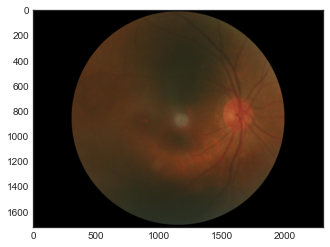